# EXPLAINABLE AI FOR HAM10000 MNIST SKIN LESION DATASET USING INVERTIBLE CONCEPT-BASED EXPLAINERS (ICE)

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from fastai.vision.all import Counter

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from PIL import Image

f:\2_Programs\anaconda3\envs\mlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set seed for reproducibility

In [2]:
RANDOM_SEED = 777

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 777


# 1. Data Setup

Before working with the dataset, I prefer to have all of the images in the same directory. This makes it more simple to access. The function below does this and only has to be run once on a local machine 

In [3]:
# Define a function to combine images in different folders into 1 folders
def combine_folders(src1, src2, dest):
    copied_files = []  # List to store names of successfully copied files

    # Create folder when destination folder not exist, exit function if destination folder contains contents from the source folder
    if not os.path.exists(dest):
      print(f"Destination folder {dest} created...")
      os.makedirs(dest)
    else:
      # Recreate folder when destination folder do not have all the contents in source folders to avoid overlapping contents
      if len(os.listdir(dest)) == (len(os.listdir(src1)) + len(os.listdir(src2))):
        print("Content in source 1 folder and source 2 folder have been copied to destination folder")
        for filename in os.listdir(dest):
            copied_files.append(filename)
        return copied_files
      else:
        shutil.rmtree(dest)
        os.makedirs(dest)

    print(f"Copying images in {src1} into {dest}...")

    # Loop through all content in source folder 1 and copy into destination folder, if source 1 folder exist
    if os.path.exists(src1):
      print('Source 1 folder consist of ', len(os.listdir(src1)), " elements")
      for images in os.listdir(src1):
        # Define the source path and the destination path for each images
        src_path = os.path.join(src1, images)
        dest_path = os.path.join(dest, images)
        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)
      print(f"All images in {src1} have been copied into {dest}...")
    else:
      print(f"{src1} not found")

    print(f"Copying images in {src2} into {dest}...")

    # loop through all content in source folder 2 and copy into destination folder, if source 2 folder exist
    if os.path.exists(src2):
      print('Source 2 folder consist of ', len(os.listdir(src2)), " elements")
      for images in os.listdir(src2):
        # Define the source path and the destination path for each images
        src_path = os.path.join(src2, images)
        dest_path = os.path.join(dest, images)
        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)
      print(f"All images in {src2} have been copied into {dest}...")
    else:
      print(f"{src2} not found")

    print('Destination folder consist of ', len(os.listdir(dest)), " elements")
    
    return copied_files

Then we will only perform the above function if the destination directory does not exist

In [4]:
dest = os.path.join(os.getcwd(), 'content', 'dataset', 'HAM10000', 'HAM10000')
print(f"Image folder is located in {dest}")

if not os.path.exists(dest):
    src1 = os.path.join(os.getcwd(), 'content', 'dataset', 'HAM10000', 'HAM10000_images_part_1')
    src2 = os.path.join(os.getcwd(), 'content', 'dataset', 'HAM10000', 'HAM10000_images_part_2')
    copied_files = combine_folders(src1, src2, dest)

Image folder is located in g:\Code\ICE_CODE\content\dataset\HAM10000\HAM10000


# 2. Data Analysis

Now let's observe the HAM10000 dataset to see what we're working with. First we'll check a couple of the rows and headings of the metadata

In [5]:
train_file = os.path.join(os.getcwd(), 'content', 'dataset', 'HAM10000', 'HAM10000_metadata.csv')
skin_train_df = pd.read_csv(train_file)
skin_train_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Here we can see what columns are necessary for our purposes. Since we're classifying purely off of the images, all we really need to use are columns `image_id` and `dx`. We'll check if any of these columns have any null values

In [6]:
# Check for null values in each attribute
print("Null counts for each attribute:")
print(skin_train_df.isnull().sum())
print()

print("Counts of 'unknown' for each attribute:")
print((skin_train_df == 'unknown').sum())

# Drop rows with null or 'unknown' values for EDA purpose
skin_df = skin_train_df.dropna()
skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]

Null counts for each attribute:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Counts of 'unknown' for each attribute:
lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    234
dtype: int64


C:\Users\etanw\AppData\Local\Temp\ipykernel_19160\561629382.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]


The columns we're using are fine so we'll drop the rest and move on to visualising the data, first by checking the classes and their distribution

In [7]:
 # Drop columns except for image_id and dx
skin_train_df = skin_train_df.drop(['lesion_id', 'dx_type', 'age', 'sex', 'localization'], axis=1)
skin_train_df.head(2)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl


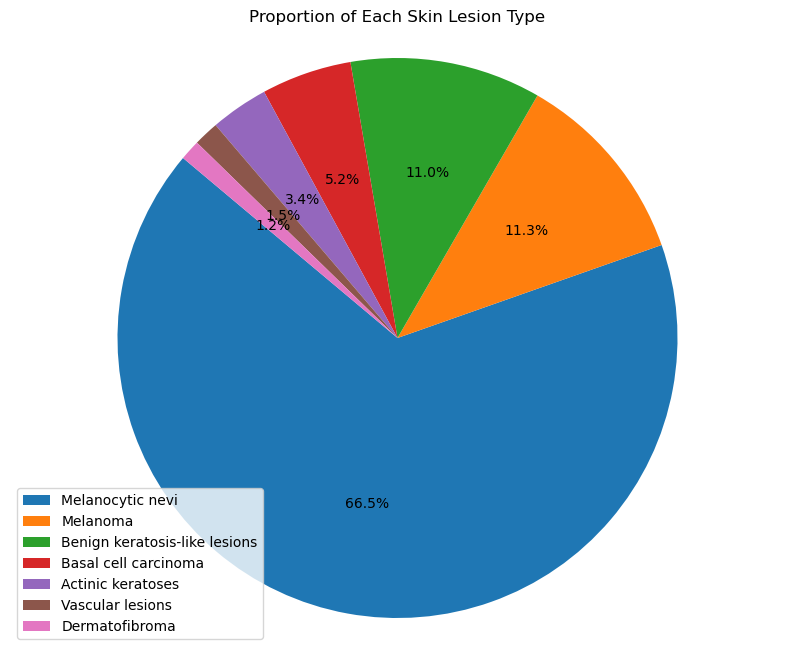

In [8]:
# Dictionary to map lesion type codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Get the counts of each lesion type
lesion_type_counts = skin_df['dx'].value_counts()

# Create labels and sizes for the pie chart
labels = [lesion_type_dict[code] for code in lesion_type_counts.index]
sizes = lesion_type_counts.values

# Create the pie chart with percentage labels
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=None, startangle=140, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Each Skin Lesion Type')

# Add a legend based on color
plt.legend(labels, loc="best")
plt.show()

Here we see a challenging feature of the HAM10000 dataset; it is heavily skewed to match typical real world proportions from clinics. This poses some issues for CNN's sometimes so we may have to preprocess the data by oversampling or undersampling in future

Let's see how many images we're dealing with...

In [9]:
print('Shape of train_df : ', skin_train_df.shape, '\n')

Shape of train_df :  (10015, 2) 



And then visualise the different classes

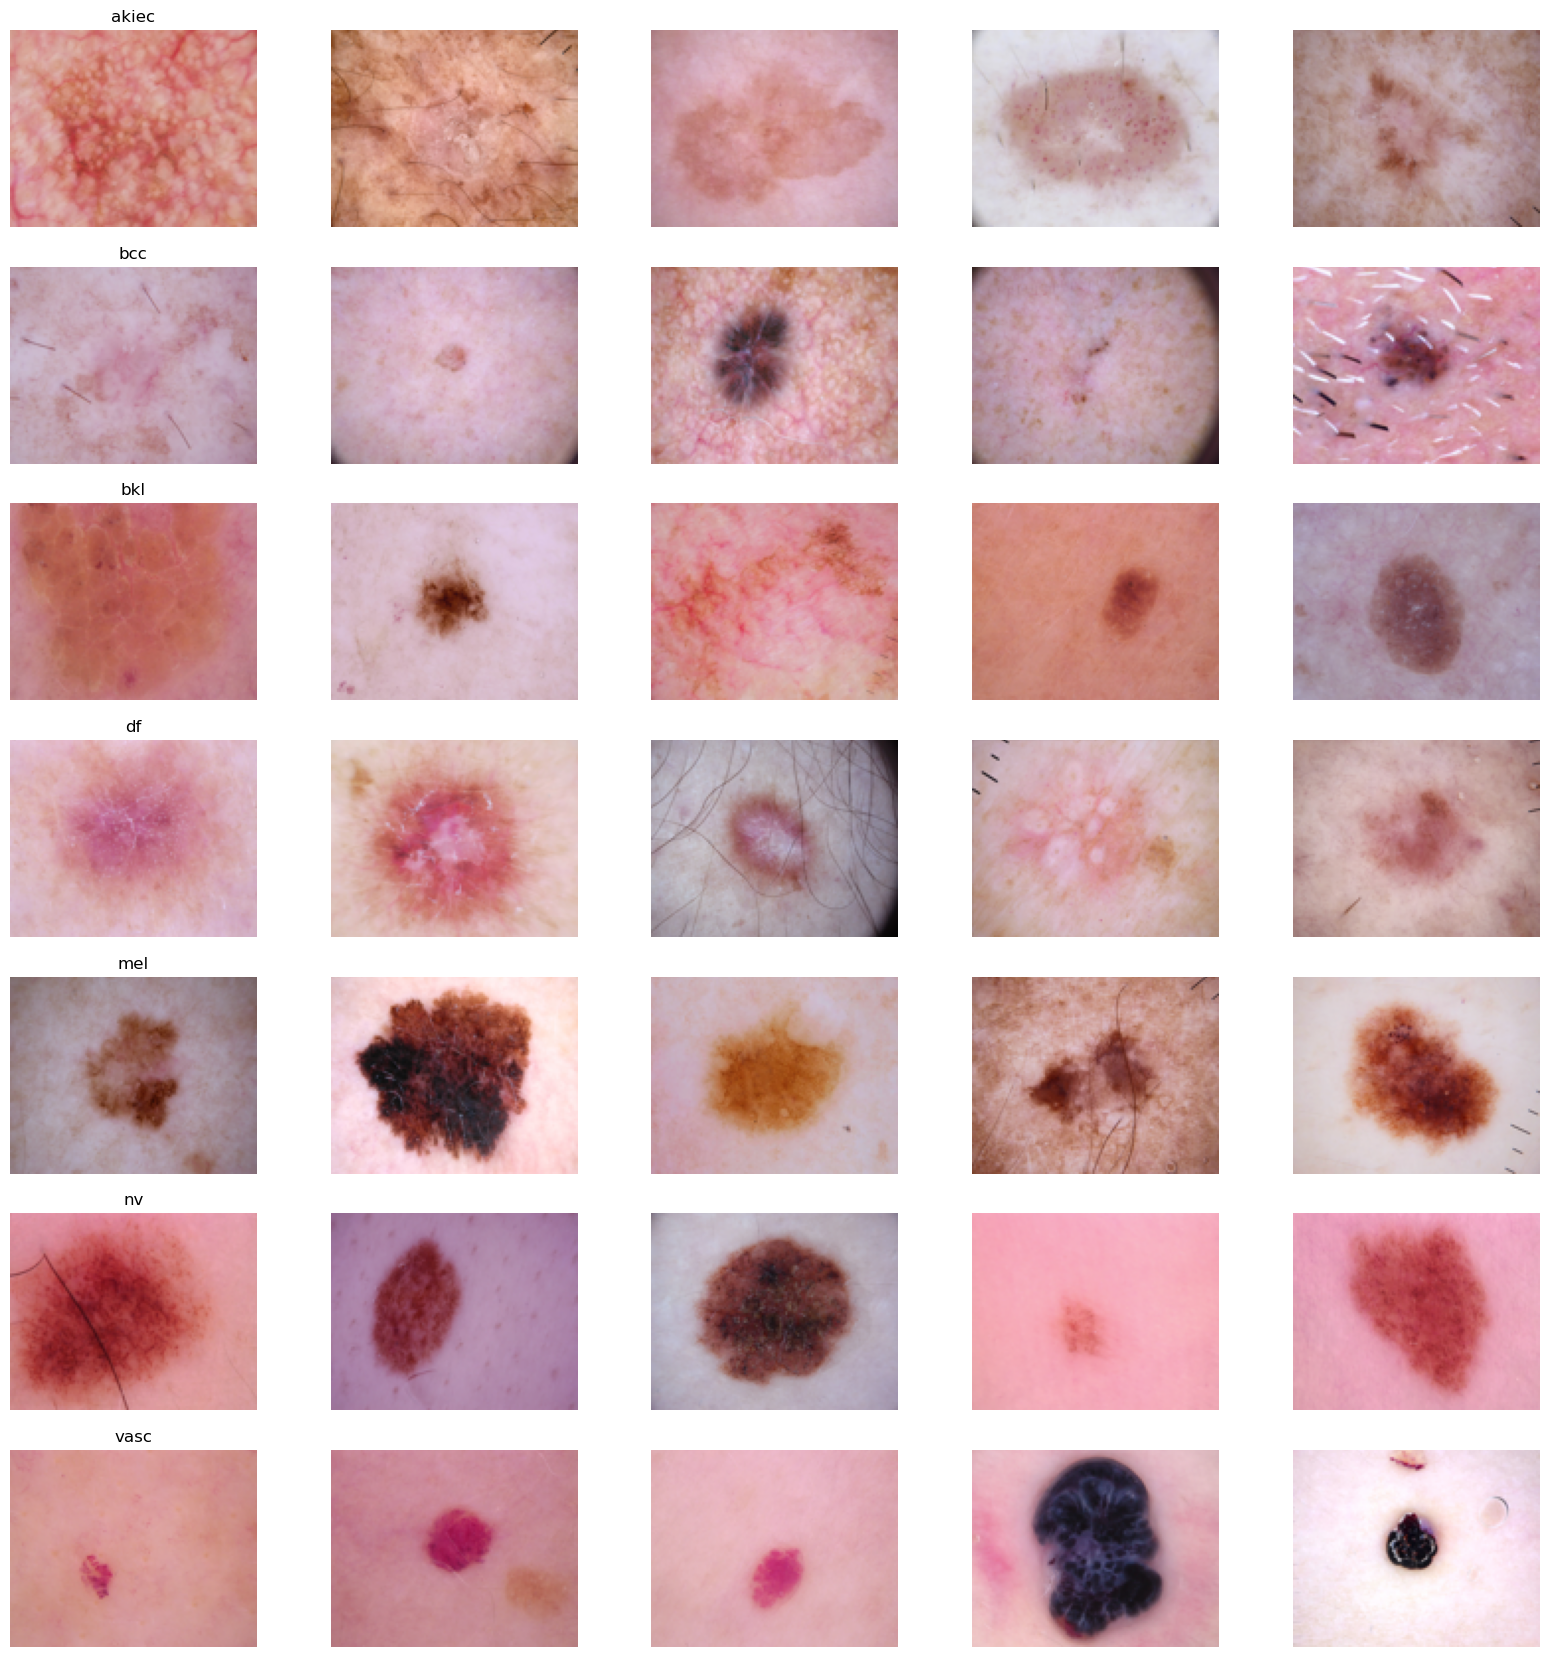

In [10]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_train_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=77).iterrows()):
        c_ax.imshow(Image.open(os.path.join(dest, c_row['image_id']+'.jpg')).resize((125,100)))
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# 3. Make Custom Dataset

Before making a dataloader, we need a dataset, and before that we need to define our transforms.

In [11]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                transforms.Resize(384),
                transforms.RandomRotation(20),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(), 
                transforms.ToTensor(),
                transforms.Normalize(mean=norm_mean, std=norm_std),
            ])

Now we make our custom dataset which will extend from PyTorch's `Dataset` class. I also want unseen test data so we'll have to split it. Let's do 90/10 split. Since the data is heavily skewed, I provide the option for oversampling to balance the data without losing information - this isn't ultimately used for this notebook though.

In [12]:
class HAM10000(Dataset):
    def __init__(self, df, root, transforms, train_mode=True, oversample=False):

        self.data = []
        self.targets = []
        self.df = df
        self.root = root
        self.train_mode = train_mode
        self.transform = transforms
        self.oversample = oversample

        if oversample:
            self.oversampled_indices = self._oversample()
            self.class_counts = Counter(self.df.iloc[self.oversampled_indices, 2])
        else:
            # append filepath to data and integer labels to targets
            for idx in range(len(self.df)):
                filename = self.df['image_id'].iloc[idx]
                filepath = os.path.join(root, filename + '.jpg')
                self.data.append(filepath)
                target = self.label_to_int(self.df['dx'].iloc[idx])
                self.targets.append(target)
            self.class_counts = Counter(self.df['dx'])

    def __len__(self):
        if self.oversample:
            return len(self.oversampled_indices)
        else:
            return len(self.df)

    # get integer that represent a class - tensors require the integers not strings
    def label_to_int(self, label):
        label_dict = {
            'nv': 0,      # Melanocytic nevi
            'mel': 1,     # Melanoma
            'bkl': 2,     # Benign keratosis-like lesions
            'bcc': 3,     # Basal cell carcinoma
            'akiec': 4,   # Actinic keratoses
            'vasc': 5,    # Vascular lesions
            'df': 6       # Dermatofibroma
        }
        return label_dict.get(label, -1)

    def __getitem__(self, idx):
        if self.oversample:
            idx = self.oversampled_indices[idx]
            img_name = os.path.join(self.root, self.df.iloc[idx, 1]+'.jpg')
            image = Image.open(img_name)
            label = self.df['dx'].iloc[idx]
            if self.transform:
                image = self.transform(image)
            label = self.label_to_int[label]
            return image, label
        else:
            img_path = self.data[idx]
            image = Image.open(img_path)
            image = self.transform(image)
            label = self.targets[idx]
            return image, label

    def _oversample(self):
        oversampled_indices = []
        for label, count in self.class_counts.items():
            indices = self.df.index[self.df['dx'] == label].tolist()
            oversampled_indices.extend(indices * (self.max_class_count // count))
            # If the count doesn't perfectly divide the maximum count,
            # randomly sample the remaining indices
            remaining_count = self.max_class_count % count
            if remaining_count > 0:
                oversampled_indices.extend(np.random.choice(indices, remaining_count))
        return oversampled_indices

    def split_train_test(self, train_ratio=0.9):
        train_size = int(train_ratio * len(self))
        test_size = len(self) - train_size
        train_set, test_set = torch.utils.data.random_split(self, [train_size, test_size])

        return train_set, test_set

    def get_class_counts(self):
        return self.class_counts

Now make the two datasets

In [13]:
# Create dataset for training, validation and testing
trainset = HAM10000(skin_train_df, dest, transform, train_mode=True)
trainset, testset = trainset.split_train_test(train_ratio=0.9)

print(f"Train set contains : {len(trainset)}")
print(f"Test set contains : {len(testset)}")

Train set contains : 9013
Test set contains : 1002


And then dataloaders

In [14]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

Now I will just quickly check some batches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


in dl


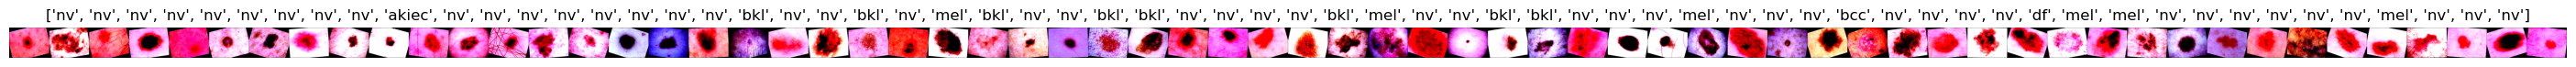

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def show_batch(images, labels):
    grid = make_grid(images, nrow=64)
    plt.figure(figsize=(36,36))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title([list(lesion_type_dict.keys())[label] for label in labels])
    plt.axis('off')
    plt.show()

for images, labels in trainloader:
    print('in dl')
    show_batch(images, labels)
    break  # Only show one batch

The batches look good, have the right distribution and have the right transforms so we'll move to defining training functions

# 4. Training Loop Definition

From testing multiple hyperparameter setups, I've ultimately found the one below as most effective. The most notable features are an SGD optimiser and learning rate scheduler to capture the intricacies further through the training

In [16]:
def train(model, dataloader, device, num_epochs, lr=0.1, momentum=0.8, step_size=5, gamma=0.5, val_loader=testloader):
    # set the optimiser
    optimiser = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    # set the scheduler
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)

    history = []
    loss_iterations = int(np.ceil(len(dataloader)/3))

    model = model.to(device)

    model.train()

    for e in range(num_epochs):
        model.train()
        print(f'Epoch {e+1:2d}/{num_epochs:d}')
        running_loss = 0.0
        running_count = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimiser.zero_grad()
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)
            labels = labels.reshape(-1, 1).float()
            outs = model(inputs)
            loss = nn.CrossEntropyLoss()(outs, labels.squeeze().long())
            loss.backward()
            optimiser.step()

            running_loss += loss.item()
            running_count += 1

            if (i + 1) % loss_iterations == 0 or i == len(dataloader) - 1:
                train_loss = running_loss / running_count
                running_loss = 0.
                running_count = 0.
                print(f'  Iter {i+1:5d}/{len(dataloader)}: train_loss = {train_loss:.4f}')

                history.append(train_loss)

        model.eval()

        running_vloss = 0.0
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                if torch.cuda.is_available():
                    vinputs, vlabels = vinputs.cuda(), vlabels.cuda()
                voutputs = model(vinputs)
                vloss = nn.CrossEntropyLoss()(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(train_loss, avg_vloss))

        history.append(avg_vloss)

        # Free memory after each epoch
        del inputs, labels, outs, loss  # Delete intermediate variables

        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Empty PyTorch cache on GPU

        # update scheduler
        scheduler.step()

    return history

# 5. Architecture Selection

ResNet50 makes the most sense here as a staple of image classification

In [17]:
# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=7)
print([name for name, _ in model.named_children()])

f:\2_Programs\anaconda3\envs\mlenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\2_Programs\anaconda3\envs\mlenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


I find that fine tuning it by making layers not require gradient computations often has produced better results. This is done here; only `layer4` is left unfrozen. We use this layer for ICE as it's the one before `avgpool`

In [18]:
# Freeze specific layers
freeze_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']

# Iterate over named modules and freeze/unfreeze as required
for name, module in model.named_children():
    if name in freeze_layers:
        for param in module.parameters():
            param.requires_grad = False
    else:
        for param in module.parameters():
            param.requires_grad = True

# 6. Saving and Loading Models

So we can save our favourite models and load them later, as well as know their training history, we need to define these functions

In [19]:
import pickle
def save_model_and_history(model, history, folder_path, name):
    model_save = os.path.join(folder_path, name+'.pt')
    history_save = os.path.join(folder_path, name+'.pkl')

    with open(history_save, 'wb') as f:
        pickle.dump(history, f)
    torch.save(model.state_dict(), model_save)

def load_model_and_history(model, folder_path, name):
    model_save = os.path.join(folder_path, name+'.pt')
    history_save = os.path.join(folder_path, name+'.pkl')

    model.load_state_dict(torch.load(model_save))
    with open(history_save, 'rb') as f:
        history = pickle.load(f)
    
    return history

In [20]:
model_name = "resnet50_3"
# Define the file path where you want to save the model
save = model_name+".pt"
save_path = os.path.join(os.getcwd(), 'content', 'models', save)

# 7. Train Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not os.path.exists(save_path):
    history = train(model, trainloader, device, num_epochs=15, lr=0.1, momentum=0.8, step_size=5, gamma=0.5)
    save_model_and_history(model, history, os.path.join(os.getcwd(), 'content', 'models'), model_name)
else:
    history = load_model_and_history(model, os.path.join(os.getcwd(), 'content', 'models'), model_name)
    epoch = 0
    for i, sub_epoch_loss in enumerate(history):
        if i % 4 == 2 or i == 0:
            print(f"Epoch {epoch}     Training Loss:    {sub_epoch_loss:.4f}")
            epoch += 1
        elif i % 4 == 3:
            print(f"                  Val Loss:         {sub_epoch_loss:.4f}")
    model = model.cuda()

Epoch 0     Training Loss:    1.4367
Epoch 1     Training Loss:    0.6897
                  Val Loss:         0.6662
Epoch 2     Training Loss:    0.5710
                  Val Loss:         0.7045
Epoch 3     Training Loss:    0.5056
                  Val Loss:         0.5170
Epoch 4     Training Loss:    0.4364
                  Val Loss:         0.4603
Epoch 5     Training Loss:    0.4057
                  Val Loss:         0.4795
Epoch 6     Training Loss:    0.3571
                  Val Loss:         0.4189
Epoch 7     Training Loss:    0.3180
                  Val Loss:         0.3971
Epoch 8     Training Loss:    0.3096
                  Val Loss:         0.4043
Epoch 9     Training Loss:    0.3069
                  Val Loss:         0.3475
Epoch 10     Training Loss:    0.2872
                  Val Loss:         0.4186
Epoch 11     Training Loss:    0.2429
                  Val Loss:         0.3467
Epoch 12     Training Loss:    0.2419
                  Val Loss:         0.3635


# 8. Evaluate Model on Test Data

This will be used for evaluating how the data performs on unseen data. We will observe the metrics of classification report and a confusion matrix

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
def evaluate(model, dataloader, device):
    # set to evaluation mode
    model.eval()

    # running_correct
    running_corrects = 0
    all_targets = []
    all_predicted = []
    all_data = torch.empty(0,3*384*512)

    for inputs, targets in dataloader:
        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            running_corrects += (targets == predicted).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())


    acc = running_corrects / len(dataloader.dataset)

    print(f'Accuracy: {acc:.2f}')
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(lesion_type_dict.keys()))
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=list(lesion_type_dict.keys()))
    disp.plot()
    plt.show()
    disp_norm.plot()
    plt.show()

    # Compute and display classification report
    report = classification_report(all_targets, all_predicted, target_names=[str(i) for i in range(7)])
    print("Classification Report:")
    print(report)
    
    '''count = 0
    for inputs, targets in dataloader:
        print(inputs.size())
        print(all_data.size())
        all_data = torch.concat((all_data, inputs.view(inputs.size(0), -1)))
        
        count+=8
        
    all_data = all_data.numpy()
    print(all_data.shape)
    all_targets = np.array(all_targets)
    all_predicted = np.array(all_predicted)
    features = all_predicted.reshape(-1,1)
    # Plot T-SNE
    tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=20, learning_rate=300, random_state=42)
    tsne_results = tsne.fit_transform(all_data)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_targets, cmap='viridis', alpha=0.7)

    # Adding a color bar
    plt.colorbar(scatter)
    plt.title('t-SNE of Model Predictions')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()'''

Accuracy: 0.93


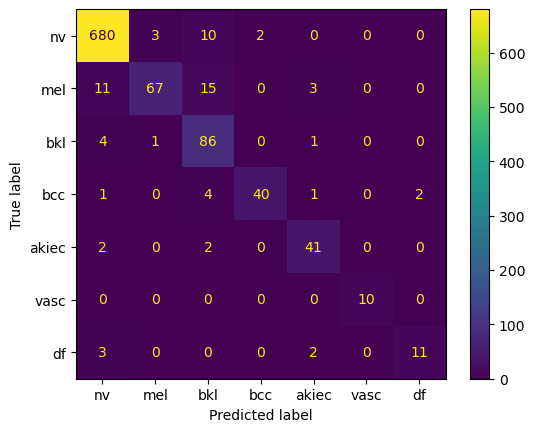

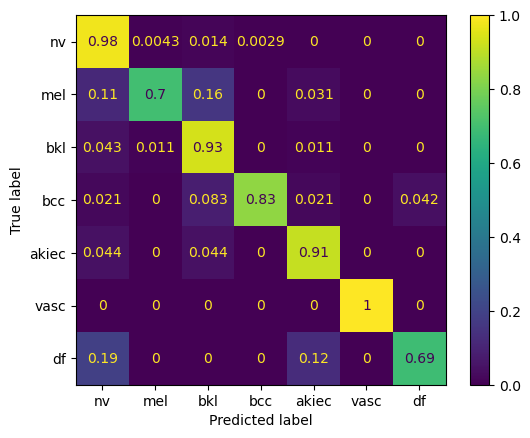

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       695
           1       0.94      0.70      0.80        96
           2       0.74      0.93      0.82        92
           3       0.95      0.83      0.89        48
           4       0.85      0.91      0.88        45
           5       1.00      1.00      1.00        10
           6       0.85      0.69      0.76        16

    accuracy                           0.93      1002
   macro avg       0.90      0.86      0.88      1002
weighted avg       0.94      0.93      0.93      1002



In [23]:
evaluate(model, testloader, device)

# 9. ICE Explanations

We need to extract the data and labels from our dataloader but also want it denormalised for displaying images. The function below will do this batchwise

In [24]:
def denormalise_batch(batch_X, norm_mean, norm_std):
    invTrans = transforms.Compose([ transforms.Normalize(
                                        mean = [0., 0., 0.],
                                        std = [1/norm_std[0], 1/norm_std[1], 1/norm_std[2]]),
                                    transforms.Normalize(
                                        mean = [-norm_mean[0], -norm_mean[1], -norm_mean[2]],
                                        std = [1., 1., 1.])
                                    ])
    inv_batch = torch.empty(0,3,224,224)
    show_image = False
    for tensor in batch_X:
        #print(tensor.shape)
        inv_tensor = invTrans(tensor).unsqueeze(0)
        if show_image:
            to_pil = torchvision.transforms.ToPILImage()
            image_pil = to_pil(inv_tensor)
            image_pil.show()

        inv_batch = torch.concat((inv_batch, inv_tensor))
    return inv_batch

Some features and imports within the ICE framework requires us to be within a specific directory.

In [25]:
os.chdir(os.path.join(os.getcwd(), 'content'))

Let's import the ICE libraries and then prepare to create explanations. This is where we can change the `target_classes` for our global explanations, `n_components` to get more concepts and hence more specific concepts, and change the `layer_name` for different model architectures (leave this as 'layer4' for resnet50)

In [33]:
import ICE.ModelWrapper as ModelWrapper
import ICE.Explainer as Explainer
import ICE.utils as utils
import shutil
from pathlib import Path

class_to_index = {
            "nv": 0,
            "mel": 1,
            "bkl": 2,
            "bcc": 3,
            "akiec": 4,
            "vasc": 5,
            "df": 6
        }
def get_class(dict, val):
    for key, value in dict.items():
        if value == val:
            return key
    return None

target_classes = [4]
classes_names = [get_class(class_to_index, i) for i in target_classes]
layer_name = 'layer4'
n_components = 10
title = "{}_{}_{}_[".format(model_name,layer_name,n_components)+"_".join(classes_names) + ']'

print ("title:{}".format(title))
print ("target_classes:{}".format(target_classes))
print ("classes_names:{}".format(classes_names))
print ("n_components:{}".format(n_components))
print ("layer_name:{}".format(layer_name))

title:resnet50_3_layer4_10_[akiec]
target_classes:[4]
classes_names:['akiec']
n_components:10
layer_name:layer4


Next we need a model wrapper for our model from ICE

In [34]:
model = model.cuda()
model.eval()
wm = ModelWrapper.PytorchModelWrapper(model,batch_size=64,predict_target=target_classes,input_size = [3,384,512],input_channel_first = True,model_channel_first = True)

For the chosen classes, we need data and target tensors with those specific classes only to use with ICE's dataloader and train a reducer.

In [35]:
if not os.path.exists(Path('tensors')):
    os.mkdir(Path('tensors'))
X_name = 'HAM_{}_X_['.format(model_name)+"_".join(classes_names) + ']'
y_name = 'HAM_{}_y_['.format(model_name)+"_".join(classes_names) + ']'
X_PATH = Path('tensors/'+ X_name +'.pt')
Y_PATH = Path('tensors/'+ y_name +'.pt')
repopulate = False

if not os.path.exists(X_PATH) or repopulate:
    print("Loading training dataset")
    X = torch.empty(0,3,384,512)
    y = torch.empty(0)
    i = 0
    divisor = 1
    for batch in trainloader:
        #batch[0] = denormalise_batch(batch[0], norm_mean, norm_std)
        if i%divisor == 0:
            data = batch[0]
            print(i)
            #print(data.shape)
            labels = batch[1]
            for target in target_classes:
                print(data[labels==target].shape)
                X = torch.concat((X, data[labels==target]))
                y = torch.concat((y, labels[labels==target]))
            print(X.shape)
        i += 1
    torch.save(X, X_PATH)
    torch.save(y, Y_PATH)
else:
    X = torch.load(X_PATH)
    y = torch.load(Y_PATH)
    print("\ntensor loaded")


tensor loaded


Make separate loaders for each target class. This is what the Explainer will take as input

In [36]:
loaders = []
for target in target_classes:
    tdataset = torch.utils.data.TensorDataset(X[y==target])
    loaders.append(torch.utils.data.DataLoader(tdataset,batch_size=64))

With all the necessary variables, we can create the explainer and then generate global explanations for the chosen classes.

In [37]:
import pickle
import PIL
print ("-------------------------------------------------------------------------------------------")
try:
    shutil.rmtree('Explainers/'+title)
except:
    pass
# create an Explainer
Exp = Explainer.Explainer(title = title,
                layer_name = layer_name,
                class_names = classes_names,
                utils = utils.img_utils(img_size = (384,512),nchannels=3,img_format='channels_first',mode='torch',mean=norm_mean,std=norm_std),
                n_components = n_components,
                reducer_type = "NMF"
               )                      

# train reducer based on target classes
Exp.train_model(wm,loaders)
# generate features 
Exp.generate_features(wm, loaders)
# generate global explanations
Exp.global_explanations()
# save the explainer, use load() to load it with the same title
#Exp.save()

-------------------------------------------------------------------------------------------
Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.90 instances
loading complete, with size of (254, 12, 16, 2048)
2/5 Reducer trained, spent 145.23845958709717 s.
3/5 Error estimated, fidelity: [0.05875754].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
loading training data
Done with class: akiec, 1/1
Generate explanations with fullset condition



torch.Size([3, 384, 512])


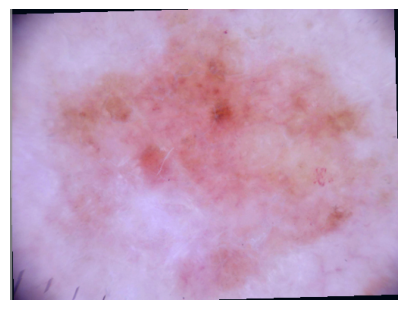

(3, 384, 512)


In [40]:
x = X[y==target][6]
print(x.size())
Exp.utils.show_img([Exp.utils.deprocessing(x.permute(2,0,1).numpy())])
#.permute(0,2,1)
x = x.numpy()
print (x.shape)

In [42]:
Exp.local_explanations(x,wm,name='LE_Akiec8')